# Modelowanie Wieloagentowe 234900-0286
## Wprowadzenie do Julia: A/B testing
### Bogumił Kamiński

## Co to jest testowanie A/B?

Metoda na prowadzenie kontrolowanego eksperymentu pozwalająca na porównanie kilku opcji i wybór najlepszej.

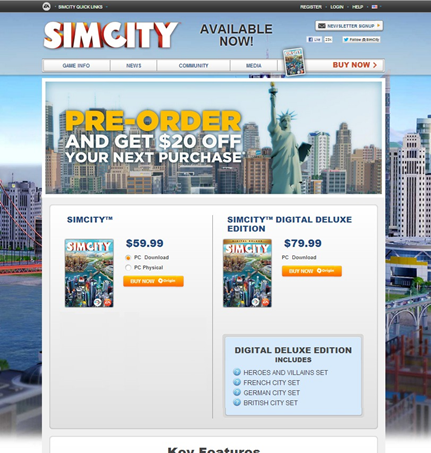

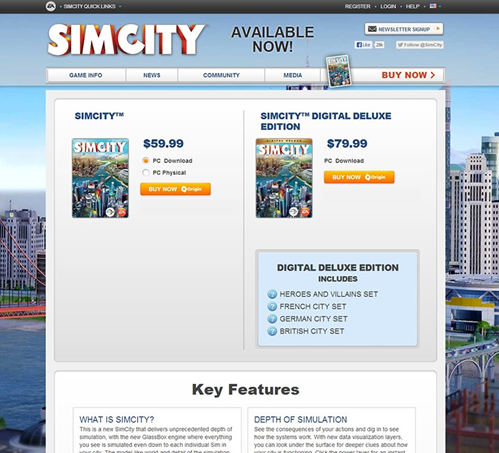

Konwersja 5.8% vs 10.2%

### Najprostsze algorytmy testowania A/B:
* Mierz każdą opcję taką samą liczbę razy. Na końcu wybierz tą, która ma najlepszą ocenę.
* Losowo wybieraj opcję do pomiaru. Na końcu wybierz tą, która ma najlepszą ocenę.
* Mierz tą opcję, która Ci się aktualnie wydaje najlepsza. Na końcu wybierz tą, która ma najlepszą ocenę.

### Eksploracja vs eksploatacja

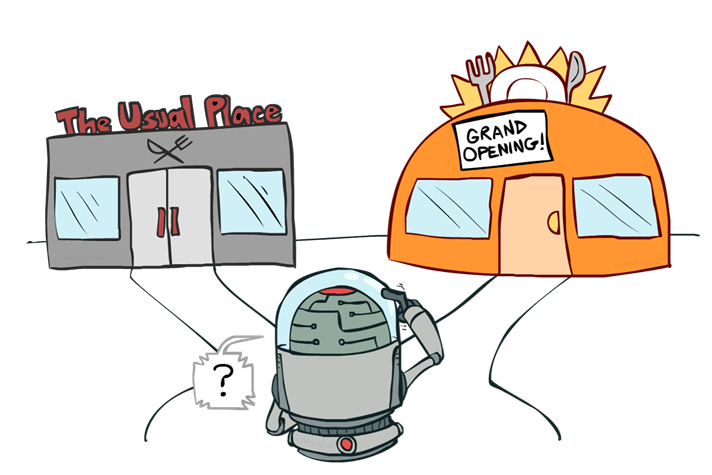

### Próbkowanie Thompsona

1. O każdej opcji w każdym momencie przechowujemy Bayesowską ocenę jej prawdopodobieństwa sukcesu.
2. Jak dokonujemy pomiaru jakiejś opcji to aktualizujemy naszą opinię o danej opcji.
3. Wyboru dokonujemy **losując** ocenę opcji z aktualnego rozkładu jej jakości w który wierzymy.

### Dlaczego to jest proste?

Rozkład Beta jest sprzężony z rozkładem Bernoulliego.

Innymi słowy jeśli wierzę, że opcja ma rozkład *Beta(a, b)* i obserwuję sukces to moja ocena będzie miała rozkład *Beta(a+1, b)*. Z kolei jeśli obserwuję porażkę, to zmienia się na *Beta(a, b+1)*.

https://en.wikipedia.org/wiki/Conjugate_prior

In [1]:
using Statistics, Distributions, PyPlot, Random, FreqTables

In [2]:
x = 0:0.001:1

0.0:0.001:1.0

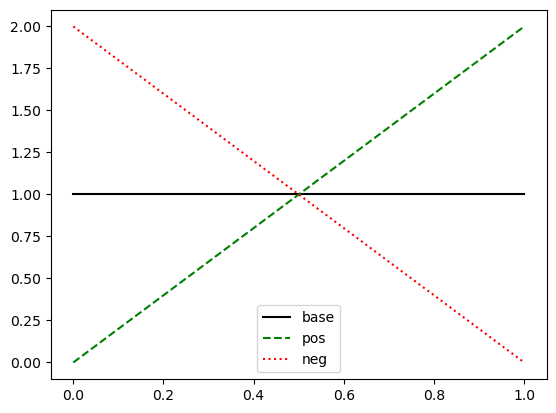

In [3]:
plot(x, pdf.(Beta(1,1), x), "-k")
plot(x, pdf.(Beta(2,1), x), "--g")
plot(x, pdf.(Beta(1,2), x), ":r")
legend(["base", "pos", "neg"]);

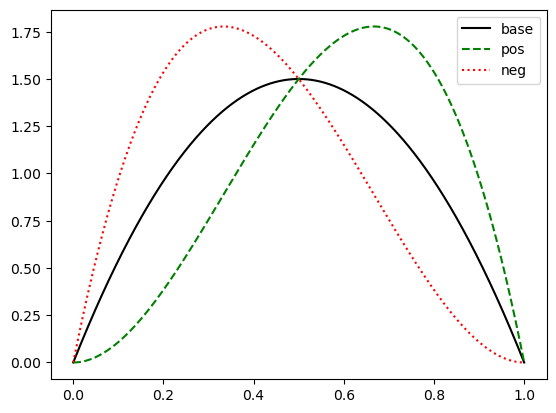

In [4]:
plot(x, pdf.(Beta(2,2), x), "-k")
plot(x, pdf.(Beta(2+1,2), x), "--g")
plot(x, pdf.(Beta(2,2+1), x), ":r")
legend(["base", "pos", "neg"]);

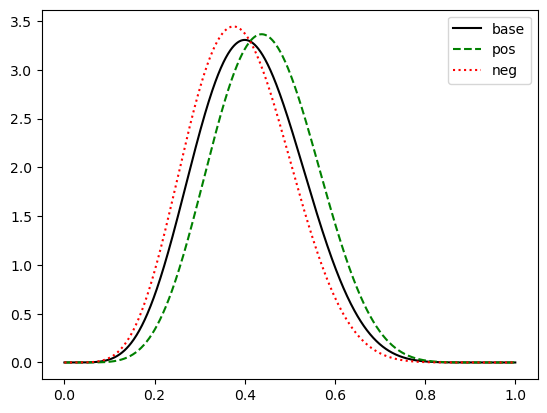

In [5]:
plot(x, pdf.(Beta(7,10), x), "-k")
plot(x, pdf.(Beta(7+1,10), x), "--g")
plot(x, pdf.(Beta(7,10+1), x), ":r")
legend(["base", "pos", "neg"]);

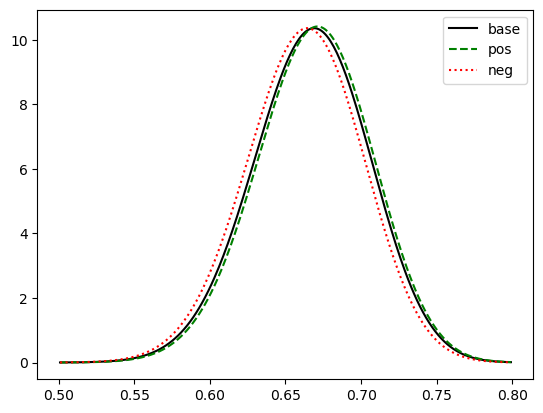

In [6]:
xs = filter(v -> 0.5 < v < 0.8, x)
plot(xs, pdf.(Beta(100,50), xs), "-k")
plot(xs, pdf.(Beta(100+1,50), xs), "--g")
plot(xs, pdf.(Beta(100,50+1), xs), ":r")
legend(["base", "pos", "neg"]);

In [7]:
update_belief(x::Beta, r::Bool) = Beta(x.α + r, x.β + !r)

update_belief (generic function with 1 method)

In [8]:
update_belief(Beta(4,5), true)

Beta{Float64}(α=5.0, β=5.0)

In [9]:
update_belief(Beta(4,5), false)

Beta{Float64}(α=4.0, β=6.0)

In [10]:
JEFFREYS = Beta(0.5,0.5)

Beta{Float64}(α=0.5, β=0.5)

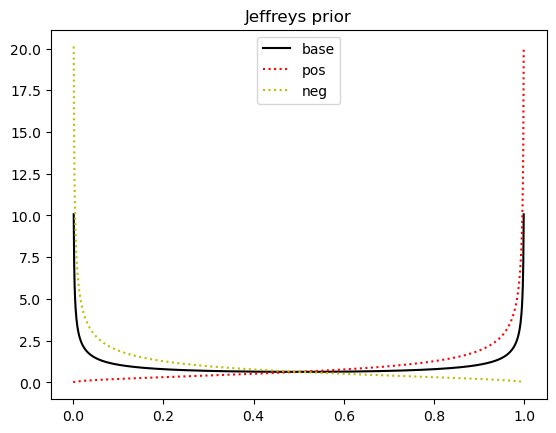

PyObject Text(0.5, 1.0, 'Jeffreys prior')

In [11]:
plot(x, pdf.(JEFFREYS, x), "-k")
plot(x, pdf.(update_belief(JEFFREYS, true), x), ":r")
plot(x, pdf.(update_belief(JEFFREYS, false), x), ":y")
legend(["base", "pos", "neg"])
title("Jeffreys prior")

In [12]:
?Bernoulli

search: Bernoulli



```
Bernoulli(p)
```

A *Bernoulli distribution* is parameterized by a success rate `p`, which takes value 1 with probability `p` and 0 with probability `1-p`.

$$
P(X = k) = \begin{cases}
1 - p & \quad \text{for } k = 0, \\
p & \quad \text{for } k = 1.
\end{cases}
$$

```julia
Bernoulli()    # Bernoulli distribution with p = 0.5
Bernoulli(p)   # Bernoulli distribution with success rate p

params(d)      # Get the parameters, i.e. (p,)
succprob(d)    # Get the success rate, i.e. p
failprob(d)    # Get the failure rate, i.e. 1 - p
```

External links:

  * [Bernoulli distribution on Wikipedia](http://en.wikipedia.org/wiki/Bernoulli_distribution)


In [13]:
function samplerun(p; n=1000, stat=mean)
    d = JEFFREYS
    m = [stat(d)]
    for i in 1:n
        d = update_belief(d, rand(Bernoulli(p)))
        push!(m, stat(d))
    end
    plot(m)
end

samplerun (generic function with 1 method)

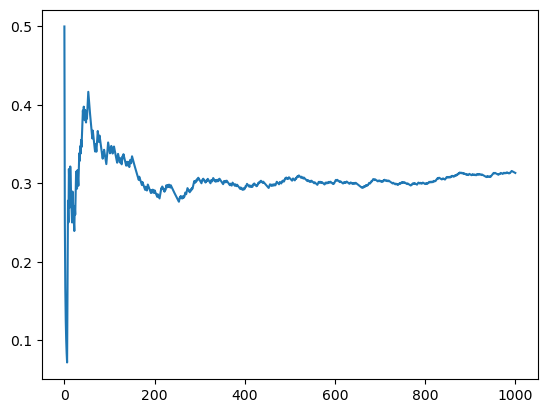

In [14]:
samplerun(0.3);

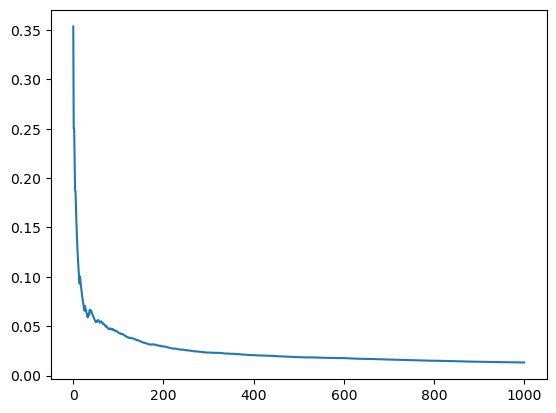

In [15]:
samplerun(0.2, stat=std);

In [16]:
abstract type ABRule end

struct Greedy <: ABRule end
struct Thompson <: ABRule end
struct Unif <: ABRule end

In [17]:
function decide(options::Vector{<:Beta}, ::Greedy)
    m = mean.(options)
    mm = maximum(m)
    return rand(findall(==(mm), m))
end

decide (generic function with 1 method)

https://en.wikipedia.org/wiki/Thompson_sampling

In [18]:
function decide(options::Vector{<:Beta}, ::Thompson)
    m = rand.(options)
    mm = maximum(m)
    return rand(findall(==(mm), m))
end

decide (generic function with 2 methods)

In [19]:
decide(options::Vector{<:Beta}, ::Unif) = rand(eachindex(options))

decide (generic function with 3 methods)

In [20]:
o1 = [Beta(1,1), Beta(11,10), Beta(10, 11)]

3-element Vector{Beta{Float64}}:
 Beta{Float64}(α=1.0, β=1.0)
 Beta{Float64}(α=11.0, β=10.0)
 Beta{Float64}(α=10.0, β=11.0)

In [21]:
mean.(o1)

3-element Vector{Float64}:
 0.5
 0.5238095238095238
 0.47619047619047616

In [22]:
prop(freqtable([decide(o1, Greedy()) for i in 1:10^5]))

1-element Named Vector{Float64}
Dim1  │ 
──────┼────
2     │ 1.0

In [23]:
prop(freqtable([decide(o1, Thompson()) for i in 1:10^5]))

3-element Named Vector{Float64}
Dim1  │ 
──────┼────────
1     │ 0.43465
2     │ 0.35456
3     │ 0.21079

In [24]:
prop(freqtable([decide(o1, Unif()) for i in 1:10^5]))

3-element Named Vector{Float64}
Dim1  │ 
──────┼────────
1     │ 0.33415
2     │ 0.33449
3     │ 0.33136

In [25]:
o2 = [Beta(10,10), Beta(11,10), Beta(10, 11)]

3-element Vector{Beta{Float64}}:
 Beta{Float64}(α=10.0, β=10.0)
 Beta{Float64}(α=11.0, β=10.0)
 Beta{Float64}(α=10.0, β=11.0)

In [26]:
mean.(o2)

3-element Vector{Float64}:
 0.5
 0.5238095238095238
 0.47619047619047616

In [27]:
prop(freqtable([decide(o2, Thompson()) for i in 1:10^5]))

3-element Named Vector{Float64}
Dim1  │ 
──────┼────────
1     │ 0.32796
2     │ 0.42968
3     │ 0.24236

In [28]:
o3 = [Beta(1000000,1000000), Beta(11,10)]
prop(freqtable([decide(o3, Thompson()) for i in 1:10^5]))

2-element Named Vector{Float64}
Dim1  │ 
──────┼────────
1     │ 0.41011
2     │ 0.58989

In [29]:
cdf(Beta(11,10), 0.5)

0.41190147399902366

In [30]:
o4 = [Beta(1000,1000), Beta(110,100), Beta(100, 110)]
prop(freqtable([decide(o4, Thompson()) for i in 1:10^5]))

3-element Named Vector{Float64}
Dim1  │ 
──────┼────────
1     │ 0.20057
2     │ 0.69055
3     │ 0.10888

In [31]:
o5 = [Beta(1000,1000), Beta(1100,1000), Beta(1000, 1100)]
prop(freqtable([decide(o5, Thompson()) for i in 1:10^5]))

3-element Named Vector{Float64}
Dim1  │ 
──────┼────────
1     │ 0.06166
2     │ 0.93778
3     │ 0.00056

In [32]:
o6 = [JEFFREYS, Beta(60, 40), Beta(60, 40)]

3-element Vector{Beta{Float64}}:
 Beta{Float64}(α=0.5, β=0.5)
 Beta{Float64}(α=60.0, β=40.0)
 Beta{Float64}(α=60.0, β=40.0)

In [33]:
mean.(o6)

3-element Vector{Float64}:
 0.5
 0.6
 0.6

In [34]:
prop(freqtable([decide(o6, Thompson()) for i in 1:10^5]))

3-element Named Vector{Float64}
Dim1  │ 
──────┼────────
1     │ 0.41871
2     │ 0.29106
3     │ 0.29023

In [35]:
# k - liczba opcji
# steps - ile kroków w symulacji robię
# alg - jaki algorytm używam
function experiment(k::Int, steps::Int, alg::ABRule)
    options = [JEFFREYS for i in 1:k]
    truep = rand(k)
    for i in 1:steps
        d = decide(options, alg)
        options[d] = update_belief(options[d], rand() < truep[d])
    end
    (correct=mean(options[argmax(truep)]) == maximum(mean.(options)),
     payoff=sum(x -> x.α - JEFFREYS.α, options))
end

experiment (generic function with 1 method)

In [36]:
experiment(3, 10, Unif())

(correct = false, payoff = 6.0)

In [37]:
using DataFrames

In [38]:
ENV["LINES"] = 10

10

In [39]:
df_unif = DataFrame([experiment(20, 1000, Unif()) for i in 1:10000])

,correct,payoff
,Bool,Float64
1,0,447.0
2,1,473.0
3,1,440.0
4,1,496.0
5,1,402.0
6,1,536.0
7,0,496.0
8,1,504.0
9,1,554.0


In [40]:
df_greedy = DataFrame([experiment(20, 1000, Greedy()) for i in 1:10000])

,correct,payoff
,Bool,Float64
1,0,617.0
2,0,816.0
3,0,726.0
4,0,788.0
5,0,935.0
6,0,906.0
7,0,791.0
8,0,863.0
9,1,877.0


In [41]:
df_thompson = DataFrame([experiment(20, 1000, Thompson()) for i in 1:10000])

,correct,payoff
,Bool,Float64
1,1,943.0
2,1,948.0
3,1,978.0
4,1,930.0
5,1,974.0
6,1,945.0
7,1,933.0
8,1,869.0
9,1,955.0


In [42]:
mapcols(mean, df_unif)

,correct,payoff
,Float64,Float64
1,0.7197,500.765


In [43]:
mapcols(mean, df_greedy)

,correct,payoff
,Float64,Float64
1,0.203,825.733


In [44]:
mapcols(mean, df_thompson)

,correct,payoff
,Float64,Float64
1,0.8835,905.558


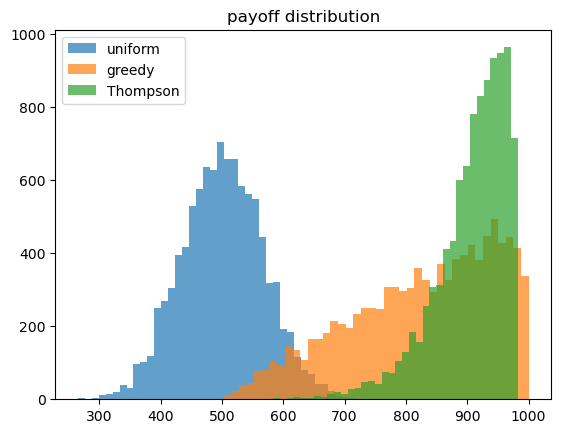

PyObject Text(0.5, 1.0, 'payoff distribution')

In [45]:
hist(df_unif.payoff, 40, alpha=0.7)
hist(df_greedy.payoff, 40, alpha=0.7)
hist(df_thompson.payoff, 40, alpha=0.7)
legend(["uniform", "greedy", "Thompson"])
title("payoff distribution")

### Dodatkowe informacje

https://arxiv.org/pdf/1707.02038.pdf

### Praca domowa

Porównaj rozważane trzy procedury próbkowania zmieniając horyzont czasowy oraz liczbę opcji (przekazujemy do Łukasza na ćwiczeniach).

In [51]:
df_unif = DataFrame([experiment(100, 1000, Unif()) for i in 1:10000])
df_greedy = DataFrame([experiment(100, 1000, Greedy()) for i in 1:10000])
df_thompson = DataFrame([experiment(100, 1000, Thompson()) for i in 1:10000])

,correct,payoff
,Bool,Float64
1,1,857.0
2,1,894.0
3,1,826.0
4,0,867.0
5,0,891.0
6,0,776.0
7,0,895.0
8,1,833.0
9,1,886.0


In [52]:
mapcols(mean, df_unif)

,correct,payoff
,Float64,Float64
1,0.1814,499.909


In [53]:
mapcols(mean, df_greedy)

,correct,payoff
,Float64,Float64
1,0.0378,829.393


In [54]:
mapcols(mean, df_thompson)

,correct,payoff
,Float64,Float64
1,0.6483,865.209


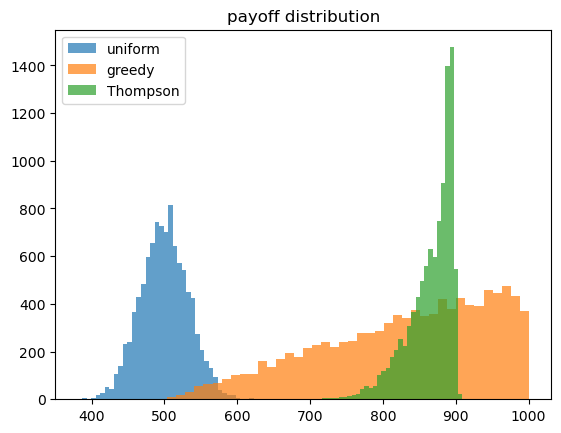

PyObject Text(0.5, 1.0, 'payoff distribution')

In [55]:
hist(df_unif.payoff, 40, alpha=0.7)
hist(df_greedy.payoff, 40, alpha=0.7)
hist(df_thompson.payoff, 40, alpha=0.7)
legend(["uniform", "greedy", "Thompson"])
title("payoff distribution")

In [56]:
df_unif = DataFrame([experiment(100, 2500, Unif()) for i in 1:10000])
df_greedy = DataFrame([experiment(100, 2500, Greedy()) for i in 1:10000])
df_thompson = DataFrame([experiment(100, 2500, Thompson()) for i in 1:10000])

,correct,payoff
,Bool,Float64
1,1,2385.0
2,1,2367.0
3,1,2305.0
4,0,2248.0
5,0,2167.0
6,1,2128.0
7,1,2372.0
8,1,2383.0
9,1,2378.0


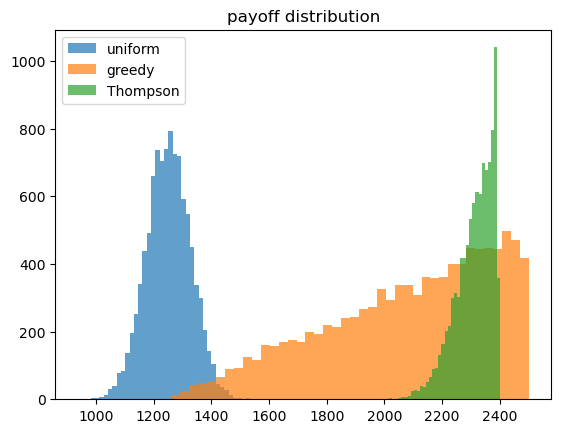

PyObject Text(0.5, 1.0, 'payoff distribution')

In [57]:
hist(df_unif.payoff, 40, alpha=0.7)
hist(df_greedy.payoff, 40, alpha=0.7)
hist(df_thompson.payoff, 40, alpha=0.7)
legend(["uniform", "greedy", "Thompson"])
title("payoff distribution")